### Word embeddings

Word embeddings are nothing but vector representations of words in a high dimensional space. These vectors are often numpy arrays. Now, one may wonder what's so special about these word vectors (aka embeddings). Well, that's how the magic happens. When these word vectors, which are basically numpy arrays, are plotted in the n-dimensional space, then words that are "similar" in the semantic sense are closer to each other in distance. For example - the words 'oranges' and 'apples' will be closer to each other than apples and vegetables or apples and shoes and so on. Word2Vec by Google was a state of the art NLP technique for finding words or sentences that are similar in a semantic sense. 

While this is great, often times, the models have to be trained using a corpus of a large number of texts to get decent results. The quality of texts also play a huge role in determining the practical efficiency of the model. 

Let's imagine a scenario where it's not possible for us to train a state of the art model using a corpus of large texts. Let's see we only have limited data to work with. This is a problem often encountered in the real world. How do we deal with this? Fear noy my friends. For it's TRANSFER LEARNING to the rescue.

### Transfer Learning

Let me start simple. If a person knows how to boil an egg, he/she must surely know how to boil potatoes? Or, if I know how to program using C, then I shouldn't have much trouble learning C++. The core basic programming concepts do not change. While I still have some learning to do, I definitely don't need to start from the very basics like I did with C. I hope we can all agree on this one. OK, let's try another one. If I can drive a Honda, surely I can drive a truck/bus too? Right? Of course they aren't the same thing. But I can use my basic knowledge of driving, roads and traffic rules to learn todrive a bus or truck. That's where Transfer learning comes in. We don't have to train our models from scratch. 

What I'm trying to state here is that we don't necessarily have to reinvent the wheel each time for a different task. So, what "transfer learning" tool am I gonna use for this project? It's __[Google's Universal Sentence encoder](https://tfhub.dev/google/universal-sentence-encoder-large/3)__.

### Universal Sentence Encoder

Google believes that sentence level encoding as opposed to word embeddings gives more meaningful results and is better at generalizing. This sentence encoder encodes each input (the input can be a word, sentence, or paragraph) into a 512 dimensional vector space. This is represented by an array of numbers. These numbers in an array don't mean much on their own. We can think of these 512 numbers as coordinates in a 512 dimensional space. The higher the dimensional space, greater the accuracy but this is comes at the expense of computational power. The Universal Sentence encoder was trained using the __[SNLI Corpus](https://nlp.stanford.edu/projects/snli/)__. This module can be used a variety of NLP tasks like clustering, classification and also for finding semantic relationships between texts.

When training models using word2Vec, we have to perform data preprocessing steps. These steps involve removing special characters, white spaces and stop words. We don't need to remove stop words when using the sentence encoder.

Google has published 2 state of the art universal sentence encoders -

1) This __[module](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ is what we'll be using. It's based on a generater encoder. It has been trained to achieve very accurate results. The tradeoff here is more compute power.

2) This __[module](https://tfhub.dev/google/universal-sentence-encoder/2)__ is based on DAN (Deep Avergaing network). This encoder is a lot easier on the RAM and our tradeoff here is some compromised accuracy. 

For more details on these encoders, please refer to this __[article by VISHWESH SHRIMALI](https://www.learnopencv.com/universal-sentence-encoder/)__.

Now, I'll try to give a visualized explanation of how this module works. I'll also using Principal Component analysis for better insights as to how this model performs. Next, I'll discuss the cosine similarity, which is a metric we'll be using to find the closest sentence embeddings which will help us retrieve the closest sentences in the semantic context!

### Cosine similarity

It is a measure of similarity between two non-zero vectors. Given two arrays of the same shape, this metric calculates the angle between these arrays (sentence embeddings which are vectors/arrays). It is important to note that magnitude of the vectors has no effect on this metric. Rather, it is the orientation that matters. It's important to note that the cos(0) is 1 and cos(90) = 0. Hence, vectors aligning in the exact same direction will have an angle of 0 degrees between them. Hence, computing the cosine (cosine similarity measure) gives us 1.

Let's take a look at the formula. The numerator represents the sum of the dot product between the vectors. The first term in the denominator represents the square root of the sum of the elements in array A. The second term represents the square root of the sum of elements in array B. 

In [4]:
Image(url= "https://alexn.org/assets/img/cosine-similarity.png")

In [9]:
#Importing the required modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
sns.set()
from sklearn.decomposition import PCA
from IPython.display import Image

In [2]:
url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [3]:
#Loading the module
embed = hub.Module(url)

INFO:tensorflow:Using C:\Users\Aditya\AppData\Local\Temp\tfhub_modules to cache modules.


The two functions defined below have been lifted straight from this __[notebook](https://github.com/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb)__ from the __[official tfhub documentation](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ .

The functions below will generate a heatmap using seaborn to understand the closeness of words, phrases or sentences.

In [ ]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
    message_embeddings_ = session_.run(encoding_tensor, feed_dict={input_tensor_: messages_})
    plot_similarity(messages_, message_embeddings_, 90)

Let us conside the list of wrds below. We know that cats are dogs are animals and are closely related to each ohter just as the fruits, oranges and apples. Let us now generate a heatmap to confirm that the sentence encoder gives us this expecrted result.

In [12]:
messages = ["cat", "dog", "apples", "oranges"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


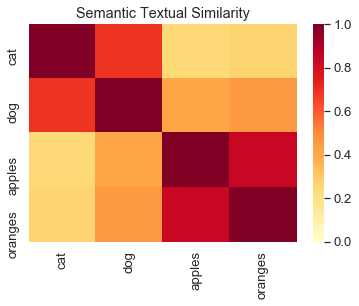

In [13]:
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    run_and_plot(session, similarity_input_placeholder, messages,similarity_message_encodings)

As expected, we see that apples and oranges are closely associated wheres cats and dogs are also closely associated.

Below, I've defined a function that generates the sentence embeddings and then, using Principal Component Analysis (PCA), squash this high dimensional space (512 to be precise) to just 2 dimensions. The goal here is to give us a better sense of how embeddings can be useful. 

In [34]:
def get_2d_representation(words_list):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        description_embeddings  =  session.run(embed(words_list)) #Generates the sentence embeddings
        
        model = PCA(n_components = 2) # Initializing the PCA object. We use n_components = 2 to help us plot our findings in the 2D space.
        # Apply the fit_transform method of model to grains: pca_features
        pca_features = model.fit_transform(description_embeddings) # Transforms embeddings to vectors of size 2
        # Assign 0th column of pca_features: xs
        xs = pca_features[:,0] #The first component of PCA
        # Assign 1st column of pca_features: ys
        ys = pca_features[:,1] #Second component of PCA
        
        #Next, we'll plot these results
        #fig, ax = plt.subplots()
        fig, ax = plt.subplots(figsize=(12,12)) 
        ax.scatter(xs, ys)        
        for i, txt in enumerate(words_list):
            ax.annotate(txt, (xs[i], ys[i]), fontsize=11)  

Now, observe the list of sentences below. Sentences 1 and 3 are one and the same. Different wordings but the same question. Sentences 1 and 2 only differ by a word but are two different questions Now let us get the sentence embeddings for these words and then, using PCA, plot these reduced vectors in the 2D space. Since sentences 1 and 3 are similar, we expect that these vectors will be closer to each other than 1 and 2 or 2 and 3. Let's check it out.

In [30]:
sentences_list = ['How are you?', 'How old are you?', 'What is your age?']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


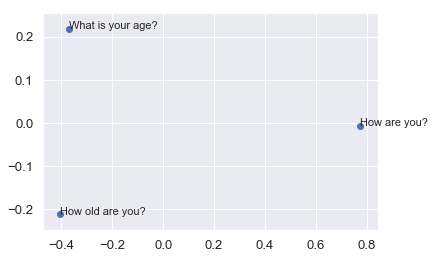

In [33]:
get_2d_representation(sentences_list)

And surprise, surpise --> That does seem to be the case. This is how word embeddings help determine semantic relationships between texts. Two different sentences could carry different words but mean the exact same thing.

Let's check out another list. We have 4 different contexts - smarphones, weather, food and health, and age. Let's see how the embeddings are mapped here.

In [23]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


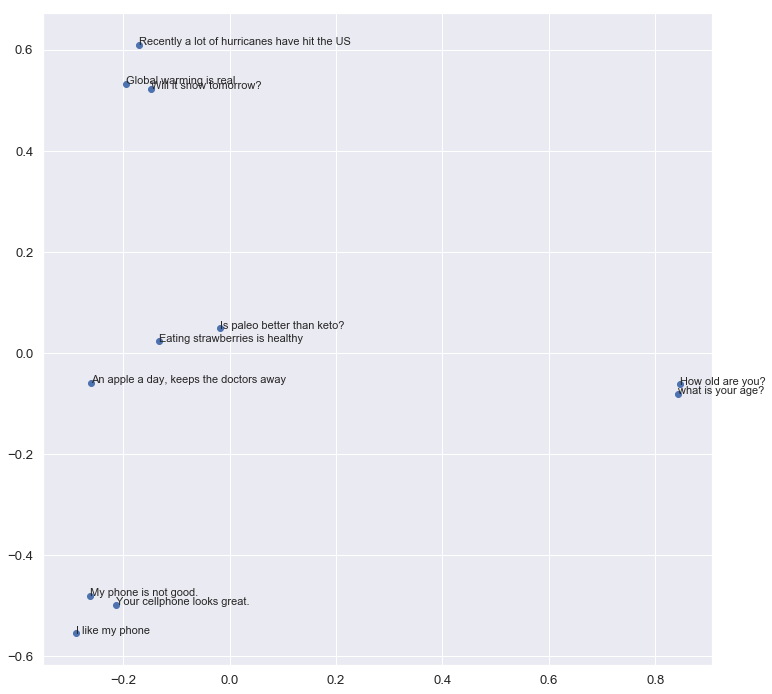

In [29]:
get_2d_representation(messages)

What an incredibl result, isn't it? The sentence embeddings have been grouped into 4 separate clusters according to the context.